In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torchvision
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
from torchvision import models,transforms

In [ ]:
torchvision.__version__

'0.10.0+cu102'

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      //documentはHTML文を取得(生成?)する
      //divタグを含んだHTML文を生成(Elemntクラス)
      const div = document.createElement('div');
      //buttonタグを含んだHTML文を生成(Elementクラス)
      //const capture = document.createElement('button');
      //文章（タグなし）を生成する
      //capture.textContent = 'Capture';

      //div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      //メディアデバイスの使用許可を求める。（ex.カメラ,オーディオ）
      //videoをTrueにしているため,ビデオデバイスの許可を得る
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      
      //bodyタグのドキュメント内にdivを挿入
      document.body.appendChild(div);
      div.appendChild(video);
      
      //メディアソース（表示する媒体）を提供するオブジェクトを設定または取得します
      video.srcObject = stream;
      //動画を再生
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      //captureがクリックされると下の処理に移る.
      //下ではキャンバスに映像に映っているものを描画して、それを画像にて処理する
      //Promise（非同期）は成功した時にresolve関数を出力する(ここではonclickがされた時resolveが出力される)
      //awaitをつけることでPromiseに値が与えられるつまり、resolveされるまで以降の処理に移らないようにする
      //await new Promise((resolve) => capture.onclick = resolve);
      
      //＊文字入力で撮るように変更する
      await new Promise(function(resolve){
          document.body.addEventListener('keydown',
          event => {
              if (event.key === 'c') {
                  resolve("撮影")
                  }
                  });
      });

      const canvas = document.createElement('canvas');
      canvas.width = 224;
      canvas.height = 224;
      center_x=canvas.width/2
      center_y=canvas.height/2
      //canvas.getContext('2d'):HTML内に何か描画する際はcanvasを使用する.この設定によって2Dグラフィックを描画することができる
      //.drawImage(video, 0, 0):(image, sx, sy, sw, sh, dx, dy, dw, dh)。image以降は表示範囲を指定する.imageには <img>要素・ <canvas>要素・ <video>要素 のいずれかを指定する
      canvas.getContext('2d').drawImage(video,center_x-112,center_y-112,224,224);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  #JavaScriptをディスプレイ
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
net=models.vgg16_bn(pretrained=False)
save_path='/content/drive/MyDrive/Colab Notebooks/中川コード/weight_fine_tuning_VGG_2Way_extenddata.pth'
net.classifier.add_module("7",nn.Linear(in_features=1000,out_features=2))
net.load_state_dict(torch.load(save_path))
net.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
transforms_func=transforms.Compose([transforms.Resize([224,224]),transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

# カメラが写されている部分をクリックしてcキーを押す

<IPython.core.display.Javascript object>

Saved to photo.jpg


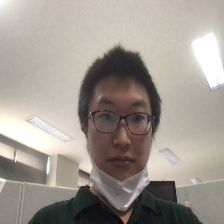

tensor([[ 0.4482, -0.4683]], grad_fn=<MulBackward0>)
ストレス値: 71.4317262172699 %


In [ ]:
from IPython.display import Image as Im
filename = take_photo()
print('Saved to {}'.format(filename))
# Show the image which was just taken.
display(Im(filename))
x="/content/photo.jpg"
img=Image.open(x)
#plt.imshow(img)
img=transforms_func(img)
#plt.imshow(img.view(-1,224,224).detach().numpy().transpose(1, 2, 0))
img=torch.unsqueeze(img,0)
pred=torch.mul(net(img),1/20)
#AF = afraid,AN = angry,DI = disgusted,HA = happy,NE = neutral,SA = sad,SU = surprised
print(pred)
print("ストレス値:",nn.functional.softmax(pred,1).detach().numpy()[0,0]*100,"%")
#print(nn.functional.softmax(pred,1).detach().numpy()[0])


In [ ]:
ccccccccccccccccccccvcccccvcccccccccccccc

NameError: ignored